# Densenet

A 5-layer dense block with a growth rate of k = 4.Each layer takes all preceding feature-maps as input.
<div style="text-align: center">
    <img src="./assets/densenet.png" width="100%">
</div>
<br>

A deep DenseNet with three dense blocks. The layers between two adjacent blocks are referred to as transition layers and change feature-map sizes via convolution and pooling.
<div style="text-align: center">
    <img src="./assets/densenet_3blocks.png" width="100%">
</div>
<br>


### Data Processing

As always, we'll start by importing all the necessary modules. We have a few new imports here:
- `lr_scheduler` for using the one cycle learning rate scheduler
- `namedtuple` for handling DenseNet configurations
- `os` and `shutil` for handling custom datasets

In [1]:
# Import required libraries for this section
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import os, cv2, copy, time
from collections import namedtuple
import random, shutil
from collections import OrderedDict
from torch import Tensor
from typing import Any, List, Optional, Tuple

Next, we'll set the random seeds for reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We'll be using our own dataset instead of using one provided by `torchvision.datasets`.

The url of the CUB200-2011 dataset can be found on its [website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html). However, the dataset is now hosted on Google Drive which has problems with files exceeding their download quota. 

Instead, we'll download the dataset from [Kaggle](https://www.kaggle.com) using the [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`.

First, we need to have a Kaggle account in order to generate an API key. Once we're logged on to Kaggle, we need to go to `https://www.kaggle.com/<username>/account` and click `Generate New API Token` which will download a `kaggle.json` file. Place this at `~/.kaggle/kaggle.json` (or, if you're on Windows, at `C:\Users\<Windows-username>\.kaggle\kaggle.json`). 

If we are using Google Colab, an alternative is simply set the environment variables `KAGGLE_USERNAME` and `KAGGLE_KEY` to their respective values. This is what we do below.

Next, we'll download the dataset from where it is hosted on Kaggle, at: https://www.kaggle.com/veeralakrishna/200-bird-species-with-11788-images. This is done with `!kaggle datasets download <kaggle-url> --unzip`, where the `<kaggle-url>` is the dataset URL after the `kaggle.com` part, which is `veeralakrishna/200-bird-species-with-11788-images` for this dataset.

[`datasets.utils`](https://github.com/pytorch/vision/blob/master/torchvision/datasets/utils.py) contains some functionality for downloading and extract data which means we don't have to write it ourselves.

We use the `extract_archive` function, which extracts a file to a given root folder. We should now have a `./../data/CUB_200_2011` folder which contains our entire dataset.

Put `CUB_200_2011.tgz` to `./../data` directory.

In [3]:
# REPLACE THESE WITH YOUR OWN KAGGLE USERNAME AND KEY
#os.environ['KAGGLE_USERNAME'] = 'YOUR_KAGGLE_USERNAME_HERE'
#os.environ['KAGGLE_KEY'] = 'YOUR_KAGGLE_KEY_HERE'

#!pip install kaggle
#!kaggle datasets download veeralakrishna/200-bird-species-with-11788-images --unzip

ROOT = './../data'

datasets.utils.extract_archive('./../data/CUB_200_2011.tgz', ROOT)

'./../data'

To handle using custom datasets, torchvision provides a [`datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) class. 

`ImageFolder` expects data to be stored in the following way:

```
root/class_x/xxy.png
root/class_x/xxz.jpg

root/class_y/123.jpeg
root/class_y/nsdf3.png
root/class_y/asd932_.jpg
```

That is, each folder in the root directory is the name of a class, and within each of those folders are the images that correspond to that class. The images in the downloaded dataset are currently in the form of:

```
CUB_200_2011/images/class_a/image_1.jpg
CUB_200_2011/images/class_a/image_2.jpg

CUB_200_2011/images/class_b/image_1.jpg
CUB_200_2011/images/class_b/image_2.jpg

CUB_200_2011/images/class_c/image_1.jpg
CUB_200_2011/images/class_c/image_2.jpg
```

This means we could call `datasets.ImageFolder(root = ./../data/CUB_200_2011/images)` and it would load all of the data. However, we want to split our data into train and test splits. This could be done with `data.random_split`, which we have used in the past to create our validation sets - but we will show how to manually create a `train` and `test` folder and store the relevant images in those folders. This way means that we only need to create a train/test split once and re-use it each time we re-run the notebook

We first set a `TRAIN_RATIO` which will decide what percentage of the images per class are used to make up the training set, with the remainder making up the test set. We create a `train` and `test` folder within the `CUB_200_2011` folder - after first deleting them if they already exist. Then, we get a list of all classes and loop through each class. For each class we get the image names, use the first `TRAIN_RATIO` of them for the training set and the remainder for the test set. We then copy - with `shutil.copyfile` - each of the images into their respective `train` or `test` folder. It is usually better to copy, rather than move, the images to create your custom splits just in case we accidentally mess up somewhere.

After running the below cell we have our training set as:

```
CUB_200_2011/images/train/class_a/image_1.jpg
CUB_200_2011/images/train/class_a/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg

CUB_200_2011/images/train/class_b/image_1.jpg
CUB_200_2011/images/train/class_b/image_2.jpg
```

and our test set as:

```
CUB_200_2011/images/test/class_a/image_48.jpg
CUB_200_2011/images/test/class_a/image_49.jpg

CUB_200_2011/images/test/class_b/image_48.jpg
CUB_200_2011/images/test/class_b/image_49.jpg

CUB_200_2011/images/test/class_c/image_48.jpg
CUB_200_2011/images/test/class_c/image_49.jpg
```

<font color=red>This train/test split only needs to be created once and does not need to be created again on subsequent runs.</font>

**Note:** `ImageFolder` will only load files that have image related extensions, i.e. jpg/jpeg/png, so if there was, for example, a `.txt` file in one of the class folders then it would not be loaded with the images. If we wanted more flexibility when deciding which files to load or not - such as not loading .png images or loading images with an esoteric format - then we could either use the `is_valid_file` argument of the `ImageFolder` class or use [`DatasetFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.DatasetFolder) and provide a list of valid extensions to the `extensions` argument.

In [4]:
TRAIN_RATIO = 0.8

data_dir = os.path.join(ROOT, 'CUB_200_2011')
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

for c in classes:
    class_dir = os.path.join(images_dir, c)
    
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        shutil.copyfile(image_src, image_dst)
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        shutil.copyfile(image_src, image_dst)

Now we've got our train/test splits we can go ahead and calculate the mean and standard deviation (std) of our dataset to normalize it. We're actually going to use a pre-trained model in this notebook so will be using the mean and std desired by the pre-trained data, so we don't actually have to calculate this - however it is left as an example.

Calculating the mean and std is slightly different than when using a dataset provided by torchvision as those datasets have all of the images stored as numpy arrays in the data's `data` attribute, whilst datasets loaded by `ImageFolder` and `DataFolder` do not.

First, we load the `train_data` from the `train` folder. Remember: the mean and std must only be calculated from the training data. This will load PIL images by default so we pass the `ToTensor` transform which converts all the PIL images to tensors and scales them from 0-255 to 0-1.

We then loop through each image and calculate the mean and std across the height and width dimensions with `dim = (1,2)`, summing all the means and stds and then finding the average by dividing them by the number of examples, `len(train_data)`.

Again, this only needs to be calculated once per dataset and the means and stds calculated here can be re-used without calculating them for other runs. The exception to this is if we used a different train/test split, then we would need to calculate these again.

In [5]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4866, 0.4999, 0.4316])
Calculated stds: tensor([0.1824, 0.1813, 0.1931])


Random crops of size 227×227 were generated from inside the 256×256 images to feed the first layer of AlexNet. Note that the paper mentions the network inputs to be 224×224, but that is a mistake and the numbers make sense with 227×227 instead.

Now to actually load our data. As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://pytorch.org/vision/stable/models.html) page.

We use the same data augmentation as always: randomly rotating, flipping horizontally and cropping.

In [6]:
pretrained_size = 227
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

We load our data with our transforms...

In [7]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

...create the validation split...

In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

...and then overwrite the validation transforms, making sure to do a `deepcopy` to stop this also changing the training data transforms.

In [9]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

To make sure nothing has messed up we'll print the number of examples in each of the data splits - ensuring they add up to the number of examples indicated on the [CUB200-2011 dataset website](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) (11,788).

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 8472
Number of validation examples: 942
Number of testing examples: 2374


Next, we'll create the iterators with the largest batch size that fits on our GPU. 

In [11]:
BATCH_SIZE = 40

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right.

In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [13]:
def plot_images(images, labels, classes, normalize = True):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (15, 15))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

We can see the images look fine, however the names of the classes provided by the folders containing the images are a little long and sometimes overlap with neighbouring images.

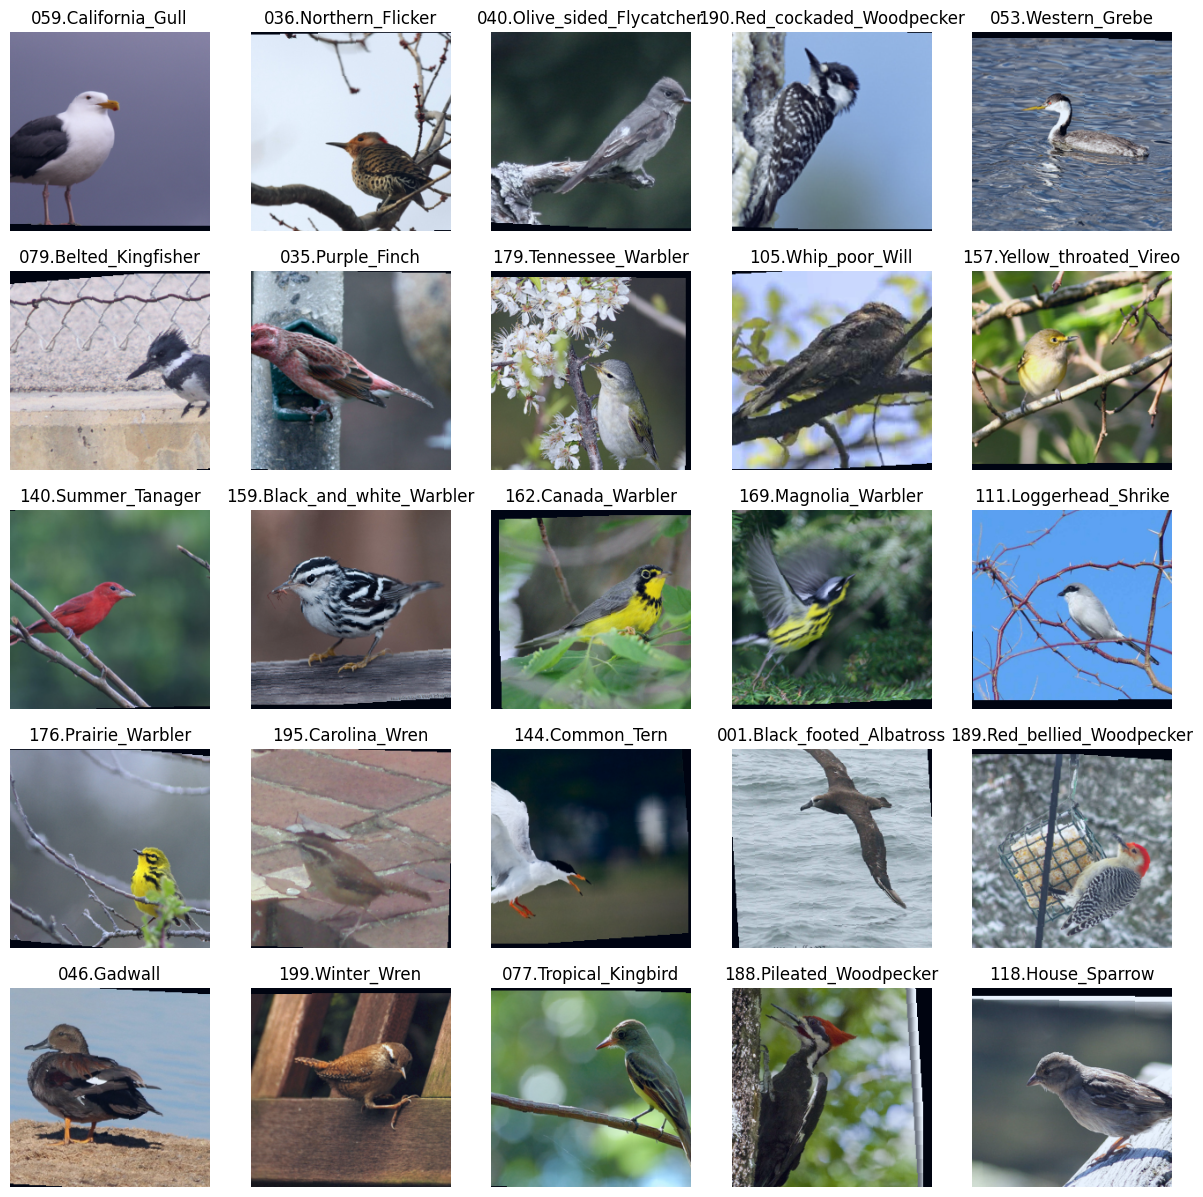

In [14]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

One way to solve the issue with the names of the classes would have been to manually change the names of the folders before we copied them over into the `train` and `test` folders. 

Another approach is to directly change the names of each class provided by the dataset's `.classes`. We'll make a `format_label` function which will strip off the number at the start of each class and convert them into title case.

In [15]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

Let's change the class names and re-plot the images with their new class names.

No more overlapping!

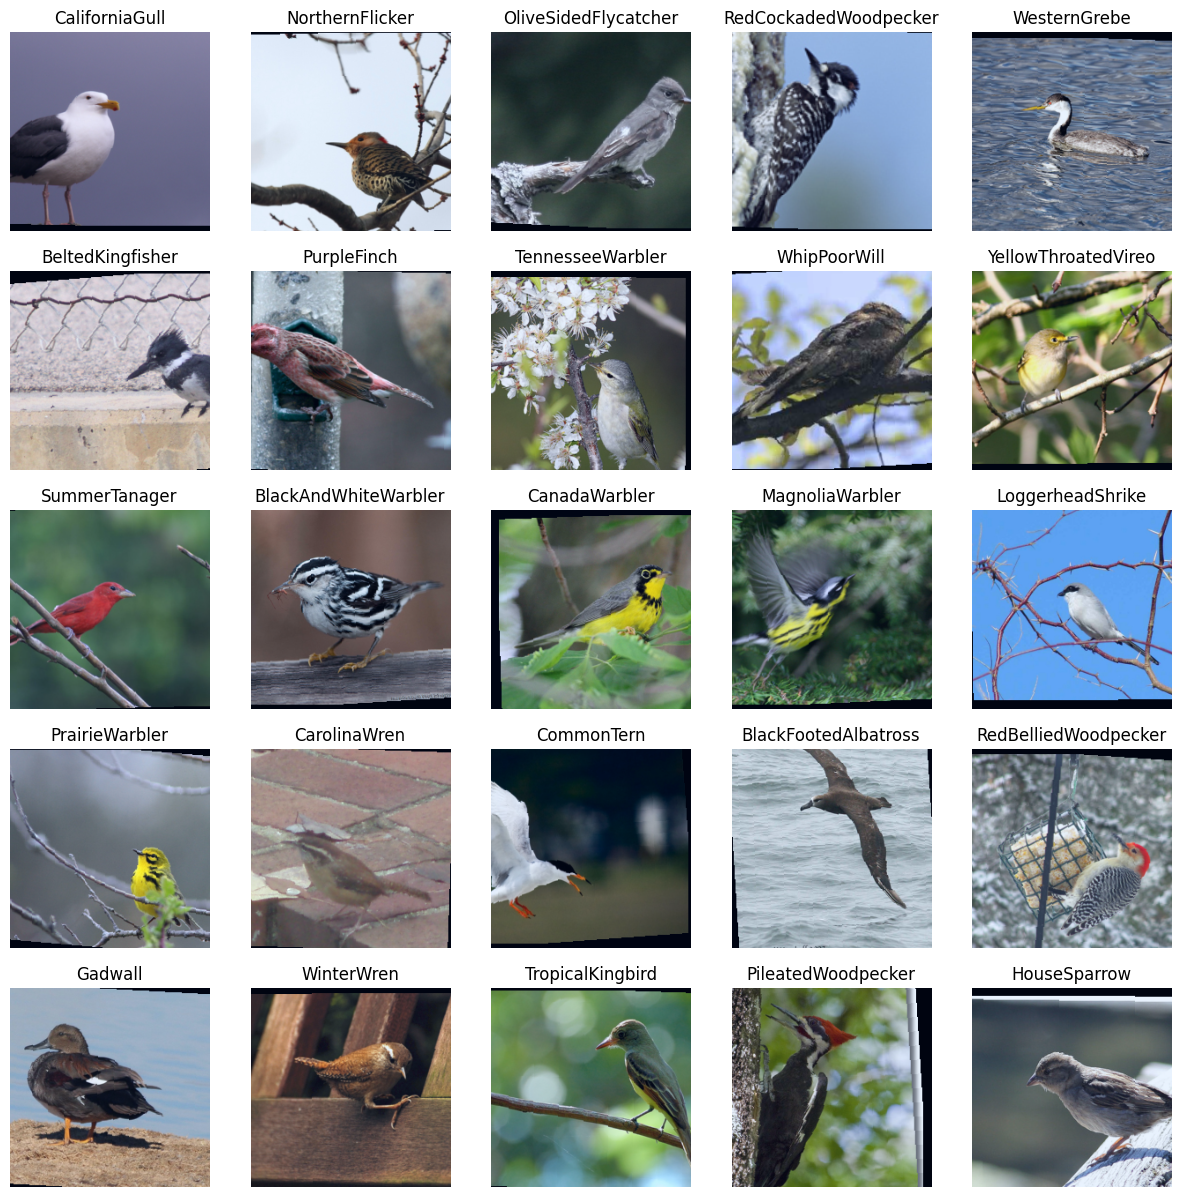

In [16]:
test_data.classes = [format_label(c) for c in test_data.classes]
classes = test_data.classes
plot_images(images, labels, classes)

### Defining the Model

Next up, we'll be defining our model. As mentioned previously, we'll be using one of the dense network (DenseNet) models. Let's look at the ResNet configuration table again:

DenseNet architectures for ImageNet. The growth rate for all the networks is k = 32. Note that each “conv” layer shown in the
table corresponds the sequence BN-ReLU-Conv.
<div style="text-align: center">
    <img src="./assets/architectures_imagenet.png" width="100%">
</div>
<br>

In [17]:
class _DenseLayer(nn.Sequential):

    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1',
                        nn.Conv2d(num_input_features, bn_size * growth_rate,
                                  kernel_size=1, stride=1, bias=False))
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

In [18]:
class _DenseBlock(nn.Sequential):

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

In [19]:
class _Transition(nn.Sequential):

    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

In [20]:
class DenseNet(nn.Module):

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):
        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=7, stride=1).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [21]:
def densenet121(pretrained=False, **kwargs):
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16), **kwargs)
    if pretrained:
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        state_dict = torch.load(os.path.join(models_dir, densenet121_model_name))
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        model.load_state_dict(state_dict)
    return model

In [22]:
def densenet161(pretrained=False, **kwargs):
    model = DenseNet(num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24), **kwargs)
    if pretrained:
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        state_dict = torch.load(os.path.join(models_dir, densenet161_model_name))
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        model.load_state_dict(state_dict)
    return model

In [23]:
def densenet169(pretrained=False, **kwargs):
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 32, 32), **kwargs)
    if pretrained:
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        state_dict = torch.load(os.path.join(models_dir, densenet169_model_name))
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        model.load_state_dict(state_dict)
    return model

In [24]:
def densenet201(pretrained=False, **kwargs):
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 48, 32), **kwargs)
    if pretrained:
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        state_dict = torch.load(os.path.join(models_dir, densenet201_model_name))
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        model.load_state_dict(state_dict)
    return model

## ToDo cifar10 network densenet.

The images in our dataset are around 500x500 pixels in size, much larger than the 32x32 images used in the CIFAR dataset. This means it's more appropriate for us to use one of the standard ResNet models, instead of the CIFAR versions.

We'll choose ResNet50 as it seems to be the most commonly used ResNet variant. 

As we have a relatively small dataset - 12,000 images - with a very small amount of examples per class - 60 images - we'll be using a pre-trained model.

Torchvision provides pre-trained models for all of the standard ResNet variants, but unfortunately not for any of the CIFAR ResNet models.

First, we load the pre-trained DenseNet model.

In [25]:
pretrained_model = models.densenet161(weights='IMAGENET1K_V1')
print(pretrained_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

We can see that the final linear layer for the classification, `fc`, has a 1000-dimensional output as it was pre-trained on the ImageNet dataset, which has 1000 classes. 

Our dataset, however, only has 200 classes, so we first create a new linear layer with the required dimensions.

In [26]:
IN_FEATURES = pretrained_model.classifier.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

Then, we replace the pre-trained model's linear layer with our own, randomly initialized linear layer.

**Note:** even if our dataset had 1000 classes, the same as ImageNet, we would still remove the linear layer and replace it with a randomly initialized one as our classes are not equal to those of ImageNet. 

In [27]:
pretrained_model.classifier = fc
print(pretrained_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

The pre-trained ResNet model provided by torchvision does not provide an intermediate output, which we'd like to potentially use for analysis. We solve this by initializing our own DenseNet161 model and then copying the pre-trained parameters into our model.

We then initialize our DenseNet161 model from the configuration...

In [28]:
model = densenet161(num_classes=OUTPUT_DIM)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

...then we load the parameters (called `state_dict` in PyTorch) of the pre-trained model into our model.

This is also a good sanity check to ensure our DenseNet model matches those used by torchvision.

In [29]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

We can also see the number of parameters in our model - noticing that ResNet50 only has ~24M parameters compared to VGG11's ~129M. This is mostly due to the lack of high dimensional linear layers which have been replaced by more parameter efficient convolutional layers.

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 26,913,800 trainable parameters


### Training the Model

Next we'll move on to training our model. As in previous notebooks, we'll use the learning rate finder to set a suitable learning rate for our model.

We start by initializing an optimizer with a very low learning rate, defining a loss function (`criterion`) and device, and then placing the model and the loss function on to the device.

In [31]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [32]:
def train(train_loader, model, criterion, optimizer, epoch, print_freq):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input = input.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec1[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})\t'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses, top1=top1, top5=top5))


The evaluation function is also similar to previous notebooks, with the addition of the top-k accuracy.

As the one cycle scheduler should only be called after each parameter update, it is not called here as we do not update parameters whilst evaluating.

In [ ]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        #for (x, y) in iterator:
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [33]:
def validate(val_loader, model, criterion, print_freq):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda()
        input = input.cuda()
        with torch.no_grad():
            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(prec1[0], input.size(0))
            top5.update(prec5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses,
                    top1=top1, top5=top5))

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))

    return top1.avg, top5.avg

In [34]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [35]:
best_prec1 = 0.0

# use cuda
model.cuda()
# model = torch.nn.parallel.DistributedDataParallel(model)

# define loss and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9,
                      weight_decay=1e-4)

In [36]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [37]:
def save_checkpoint(state, is_best, filename='alex_checkpoint.pth'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'alex_model_best.pth')

In [ ]:
model_arch='densenet'
for epoch in range(0, 10):
    adjust_learning_rate(optimizer, epoch, 0.01)

    # train for one epoch
    train(train_iterator, model, criterion, optimizer, epoch, 10)

    # evaluate on validation set
    prec1, prec5 = validate(valid_iterator, model, criterion, 10)

    # remember the best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    save_checkpoint({
        'epoch': epoch + 1,
        'arch': model_arch,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict()
    }, is_best, model_arch + '.pth')

Epoch: [0][0/212]	Time 1.011 (1.011)	Data 0.164 (0.164)	Loss 5.3255 (5.3255)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)	
Epoch: [0][10/212]	Time 0.275 (1.420)	Data 0.174 (1.238)	Loss 5.3526 (5.2949)	Prec@1 0.000 (1.364)	Prec@5 0.000 (1.364)	
Epoch: [0][20/212]	Time 0.273 (0.880)	Data 0.172 (0.736)	Loss 5.1698 (5.2219)	Prec@1 5.000 (3.095)	Prec@5 5.000 (3.095)	
Epoch: [0][30/212]	Time 1.467 (1.098)	Data 1.366 (0.966)	Loss 5.0729 (5.0893)	Prec@1 2.500 (4.597)	Prec@5 2.500 (4.597)	
Epoch: [0][40/212]	Time 0.289 (0.903)	Data 0.187 (0.779)	Loss 4.1681 (4.8981)	Prec@1 17.500 (7.012)	Prec@5 17.500 (7.012)	
Epoch: [0][50/212]	Time 2.172 (0.941)	Data 2.063 (0.821)	Loss 3.7062 (4.7052)	Prec@1 20.000 (9.069)	Prec@5 20.000 (9.069)	
Epoch: [0][60/212]	Time 0.280 (0.909)	Data 0.178 (0.791)	Loss 3.3623 (4.4973)	Prec@1 35.000 (11.557)	Prec@5 35.000 (11.557)	
Epoch: [0][70/212]	Time 0.295 (1.002)	Data 0.189 (0.885)	Loss 3.1204 (4.3098)	Prec@1 17.500 (13.768)	Prec@5 17.500 (13.768)	
Epoch: [0][80/212]	Ti

Epoch: [2][170/212]	Time 0.288 (1.015)	Data 0.186 (0.911)	Loss 0.8134 (0.6509)	Prec@1 85.000 (82.251)	Prec@5 85.000 (82.251)	
Epoch: [2][180/212]	Time 0.281 (0.976)	Data 0.176 (0.871)	Loss 0.7244 (0.6522)	Prec@1 77.500 (82.307)	Prec@5 77.500 (82.307)	
Epoch: [2][190/212]	Time 0.293 (1.009)	Data 0.191 (0.904)	Loss 0.8053 (0.6517)	Prec@1 80.000 (82.264)	Prec@5 80.000 (82.264)	
Epoch: [2][200/212]	Time 0.283 (0.974)	Data 0.179 (0.869)	Loss 0.5927 (0.6561)	Prec@1 87.500 (82.077)	Prec@5 87.500 (82.077)	
Epoch: [2][210/212]	Time 0.287 (1.002)	Data 0.182 (0.897)	Loss 0.6310 (0.6565)	Prec@1 85.000 (82.121)	Prec@5 85.000 (82.121)	
Test: [0/24]	Time 0.229 (0.229)	Loss 1.0216 (1.0216)	Prec@1 67.500 (67.500)	Prec@5 90.000 (90.000)
Test: [10/24]	Time 0.236 (1.694)	Loss 1.0902 (1.0219)	Prec@1 70.000 (69.318)	Prec@5 97.500 (94.318)
Test: [20/24]	Time 3.510 (1.213)	Loss 1.2131 (1.0161)	Prec@1 65.000 (71.071)	Prec@5 90.000 (93.571)
 * Prec@1 70.913 Prec@5 93.418
Epoch: [3][0/212]	Time 0.255 (0.255)	Dat

In [ ]:
torch.cuda.empty_cache()

The test accuracies are a little lower than the validation accuracies, but not by so much that we should be concerned.

In [ ]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

### Examining the Model

We'll be doing the same examinations of the model as done in previous notebooks.

First, we get the predictions for each image in the test set...

In [ ]:
def get_predictions(model, iterator):
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)

... which we then use to get the predicted labels.

In [ ]:
pred_labels = torch.argmax(probs, 1)

We then use this to plot a confusion matrix.

A 200x200 confusion matrix is pretty large, so we've increased the figure size and removed the colorbar. The text is still too small to read, but all we care about is that the diagonals are generally darker than the rest of the matrix - which they are.

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (50, 50));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

We can then get all of the correct predictions, filter them out, and then sort all of the incorrect predictions based on how confident they were on their incorrect prediction.

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot the most incorrectly predicted images along with the predicted class and the actual class. 

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

From the names of the classes (and a bit of image searching) we can see that the incorrect predictions are usually sensible, e.g. magnolia warbler and cape may warbler, marsh wren and carolina wren.

The most incorrectly predicted image might also be a mislabeled example as worm eating warblers do not have a black and white underside.

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

We can also get the representations from the model in order to perform some dimensionality reduction techniques.

In this notebook we'll only get the output representations, and not the intermediate ones.

In [ ]:
def get_representations(model, iterator):
    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        #for (x, y) in iterator:
        for (x, y) in tqdm(iterator):
            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
outputs, labels = get_representations(model, train_iterator)

We can then perform PCA on these representations to plot them in two dimensions.

In [ ]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

As there are 200 classes, it is difficult for every class to have a unique color. 

Also a legend with 200 elements is quite large, so we do not plot it - however we leave the code (commented out) to do so if required.

In [ ]:
def plot_representations(data, labels, classes, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')
    #handles, _ = scatter.legend_elements(num = None)
    #legend = plt.legend(handles = handles, labels = classes)

The classes do not seem as well separated as in previous notebooks, although this is most probably due to there being so many classes.

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

Next up, we plot the t-SNE data. As we have a much smaller dataset than the CIFAR datasets used previously we can perform t-SNE on the entire dataset in a reasonable amount of time.

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

The classes are definitely well separated here - which is usually a good sign.

In [ ]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)

We can then plot what a few of the images look like after having gone through the first convolutional layer.

In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):
    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

We can see that the filters perform many different types of image processing - from edge detection to color inversion.

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the values of the filters themselves.

In [ ]:
def plot_filters(filters, normalize = True):
    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):
        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

There are some interesting patterns contained in these filters, however all of these were already present in the pre-trained ResNet model. The learning rate used on this initial convolutional layer was most probably too small to change these significantly.

In [ ]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- downloading and extracting custom datasets
- loading custom datasets
- calculating the mean and std for normalization on custom datasets
- loading transforms to augment and normalize our data
- defining a ResNet model
- defining the ResNet blocks
- defining a CIFAR ResNet model
- loading a pre-trained model
- loading pre-trained model parameters into a defined model
- how to use the learning rate finder
- how to use discriminative fine-tuning
- how to use the one cycle learning rate scheduler
- fine-tuning a pre-trained model to achieve ~80% top-1 accuracy and ~95% top-5 accuracy on a dataset with 200 classes and only 60 examples per class
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- viewing the learned weights of our model

# Free GPU mempory

In [ ]:
import os
 
pid = os.getpid()
!kill -9 $pid

# End